# **Preprocess Data and Create Labels and Features**

In [1]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
import keras
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

In [22]:
#FOR UPGRADED SEQUENCE
DATA_PATH = os.path.join('More_Sign_Data')

# actions = np.array(['maaf', 'tolong'])

actions = np.array(['terimakasih'])

# actions = np.array(['maaf', 'tolong', "terimakasih", "nama", "saya", "kamu", "siapa"])

# menggunakan 60 video
no_sequences = 40

# setiap video berisi 30 frame
sequence_length = 30

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'terimakasih': 0}

In [26]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            print(frame_num + 1)
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num + 1)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
1

In [145]:
np.array(sequences).shape

(80, 30, 108)

In [146]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [148]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 30, 108)
(8, 30, 108)
(72, 2)
(8, 2)


# **Build and Train LSTM Neural Network**

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [150]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [151]:
# SIMPLE MODEL -> MAIN MODEL
model = Sequential()

model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,108)))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [105]:
# COMPLEX MODEL -> EXPERIMENTAL
model = Sequential()

model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [152]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 30, 64)            44288     
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 57266 (223.70 KB)
Trainable params: 57266 (223.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [153]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [154]:
train_model = model.fit(X_train, y_train, epochs=40, callbacks=[tb_callback])

Epoch 1/40
3/3 [==============================] - 3s 20ms/step - loss: 0.6969 - categorical_accuracy: 0.5417
Epoch 2/40
3/3 [==============================] - 0s 17ms/step - loss: 0.6848 - categorical_accuracy: 0.5417
Epoch 3/40
3/3 [==============================] - 0s 18ms/step - loss: 0.6827 - categorical_accuracy: 0.5417
Epoch 4/40
3/3 [==============================] - 0s 18ms/step - loss: 0.6811 - categorical_accuracy: 0.5417
Epoch 5/40
3/3 [==============================] - 0s 19ms/step - loss: 0.6643 - categorical_accuracy: 0.5417
Epoch 6/40
3/3 [==============================] - 0s 19ms/step - loss: 0.6617 - categorical_accuracy: 0.5417
Epoch 7/40
3/3 [==============================] - 0s 18ms/step - loss: 0.6479 - categorical_accuracy: 0.5417
Epoch 8/40
3/3 [==============================] - 0s 19ms/step - loss: 0.6253 - categorical_accuracy: 0.5417
Epoch 9/40
3/3 [==============================] - 0s 19ms/step - loss: 0.5952 - categorical_accuracy: 0.6111
Epoch 10/40
3/3 [==

In [56]:
print(train_model.history.keys())

dict_keys(['loss', 'categorical_accuracy'])


KeyError: 'val_categorical_accuracy'

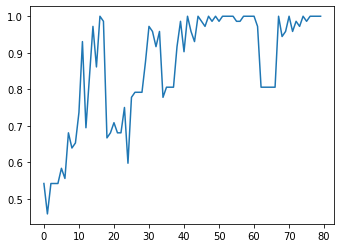

In [57]:
# Plotting the accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot = accuracy
plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting the loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot = loss
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Make Predictions**

In [58]:
res = model.predict(X_test)

1/1 [==============================] - 1s 962ms/step


In [59]:
actions[np.argmax(res[4])]

'maaf'

In [60]:
actions[np.argmax(y_test[4])]

'maaf'

# **Save Weights**

In [61]:
model.save('action.h5')

C:\Users\krisn\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
del model

In [ ]:
model.load_weights('action.h5')

# **Evaluation using Confusion Matrix and Accuracy**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)